# Notebook 5: Condition-Based Differential Expression Analysis

##  Purpose: Identifies genes responding to specific biological conditions rather than computational clusters, 
testing the paper's key hypotheses about macrophage responses to K. pneumoniae infection.
  
###  Key Comparisons:
  1. Overall infection response (infected_vs_control) - General immune activation
  2. Cell type-specific responses (am/im_infected_vs_control) - How AMs vs IMs respond differently
  3. Direct bacterial contact (bacterial_vs_bystander) - M(Kp) signature identification
  4. Cell type-specific bacterial contact - Refined M(Kp) responses

###  What to Look For:

  General infection (comparison 1):
  - Immune activation genes (TNF, IL1B, interferon response)
  - Inflammatory pathways

  AM vs IM responses (comparison 2):
  - IMs: Stronger interferon/antiviral response (Stat1, Gbp genes)
  - AMs: Tissue homeostasis, phagocytosis genes

  Bacterial+ vs Bystander (comparison 3) - MOST IMPORTANT:
  - M(Kp) signature genes - novel polarization state
  - STAT6 pathway targets - key mechanistic finding
  - Bacterial recognition/processing genes
  - Should be distinct from general inflammation

###  Key Validation: Do the Kp+ (Klebsiella-contacted cells) upregulated genes match their reported M(Kp) signature and show STAT6 pathway enrichment (Notebook 6)?
  In these plots we are looking for:
  - STAT6 pathway genes upregulated in your bacterial+ vs bystander comparison
  - Genes involved in capsule polysaccharide recognition
  - Novel antimicrobial programs distinct from typical bacterial responses

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#clean start with the QCed data, using 0.5 resolution as was determined in notebook 4
adata = sc.read_h5ad('QCed_GSE184290.h5ad')
sc.tl.leiden(adata, flavor="igraph", key_added="leiden", resolution=0.5)

In [5]:
# Check metadata 
#print("Available metadata columns:")
#print(adata.obs.columns.tolist())
#print("\nSample of metadata:")
#print(adata.obs.head())
#
## Check unique values in key columns
#for col in adata.obs.columns:
#    if adata.obs[col].dtype == 'object' or adata.obs[col].dtype.name == 'category':
#        print(f"\n{col} values:")
#        print(adata.obs[col].value_counts())

In [6]:
# Create cleaner condition labels
adata.obs['cell_type'] = adata.obs['title_x'].str.split('_').str[0]  # AM or IM
adata.obs['condition'] = adata.obs['title_x'].str.split('_').str[1]  # Control, KP+, KP-

print("Cell type distribution:")
print(adata.obs['cell_type'].value_counts())
print("\nCondition distribution:")
print(adata.obs['condition'].value_counts())

Cell type distribution:
cell_type
IM    1248
AM    1151
Name: count, dtype: int64

Condition distribution:
condition
KP+        810
KP-        798
Control    791
Name: count, dtype: int64


### Compare Expression by Condition - All Data

#### 1. Overall (Infected vs Control)
#### Biological Question: "What genes respond to infection vs healthy tissue?"

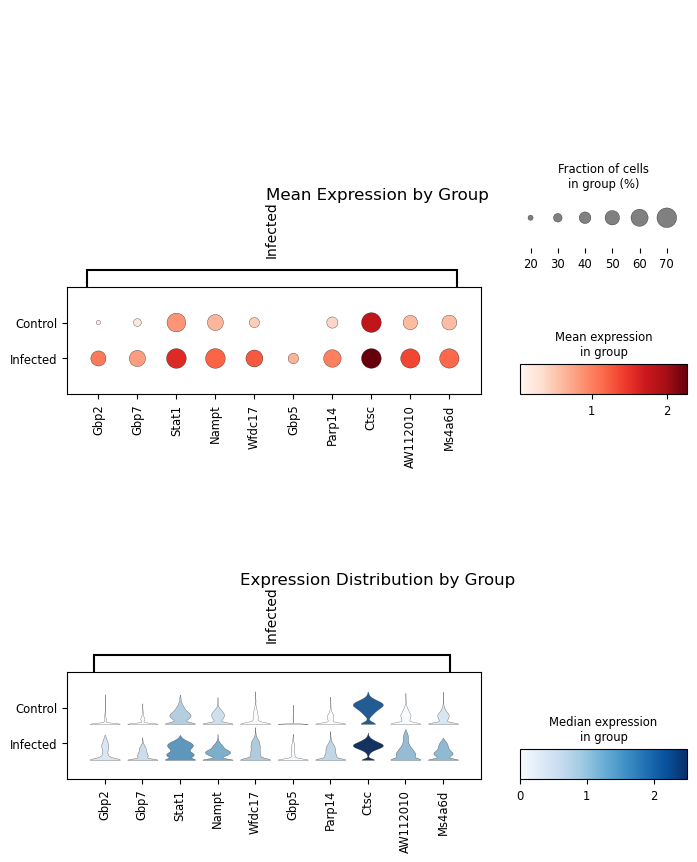

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key='infected_vs_control',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=10, key='infected_vs_control',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
for text in ax2.texts:
    text.remove()
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

#### 2. IMs (Infected vs Control)
#### Biological Question: "What genes respond to infection vs healthy tissue in IMs (interstitial macrophages)?"

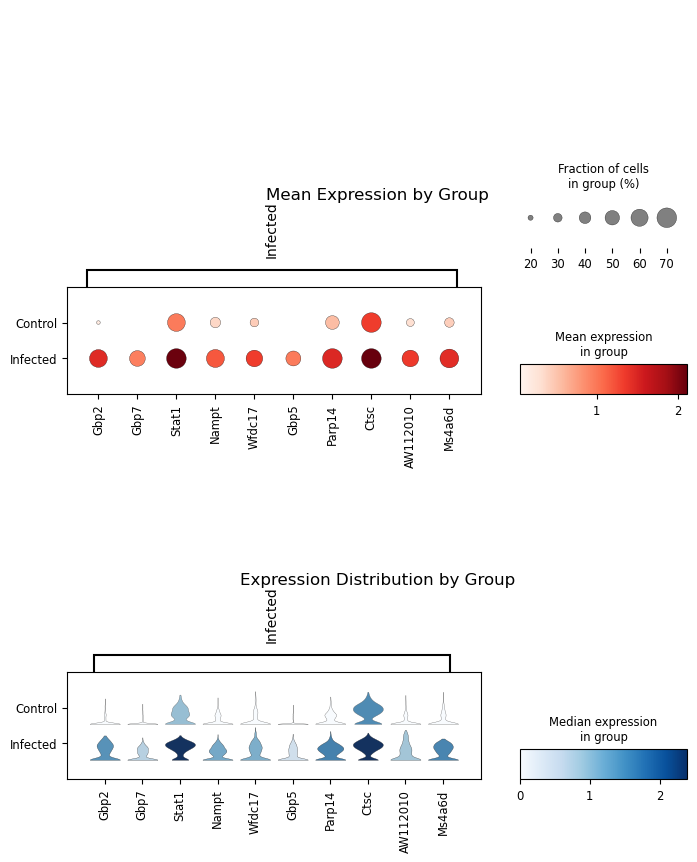

In [73]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(im_cells, n_genes=10, key='infected_vs_control',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(im_cells, n_genes=10, key='infected_vs_control',
                                      ax=ax2, show=False, dendrogram=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()


#### 3. AMs (Infected vs Control)
#### Biological Question: "What genes respond to infection vs healthy tissue in AMs (alveolar macrophages)?"

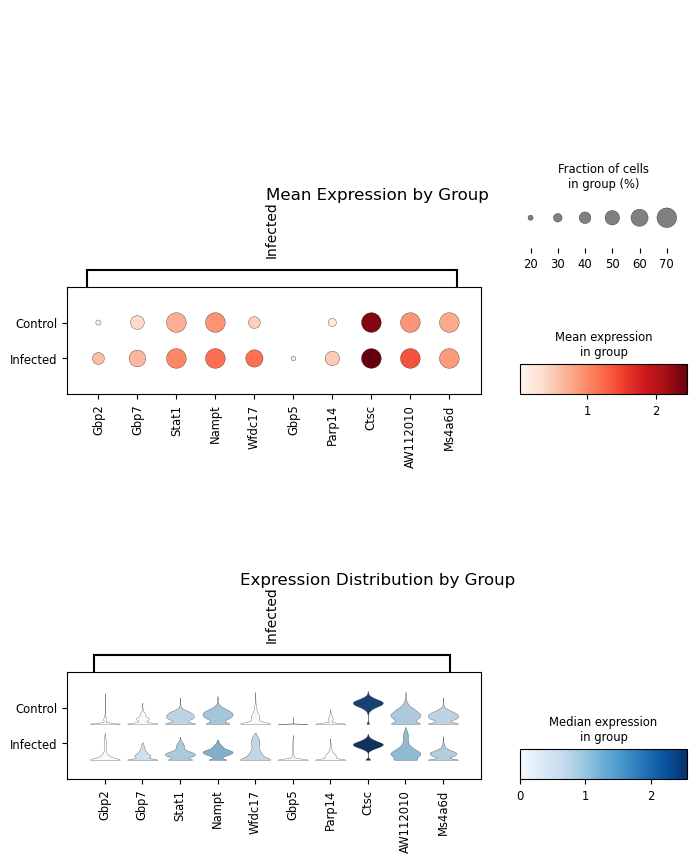

In [74]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(am_cells, n_genes=10, key='infected_vs_control',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(am_cells, n_genes=10, key='infected_vs_control',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

### Compare Expression by Condition - Infected Tissue Only

#### 4. Klebsiella-Contacted Cells vs Bystander Cells
#### Biological Question: "Infected tissue subset: "Within infected tissue, what's different between cells that contacted the Klebsiella vs those that didn't?"

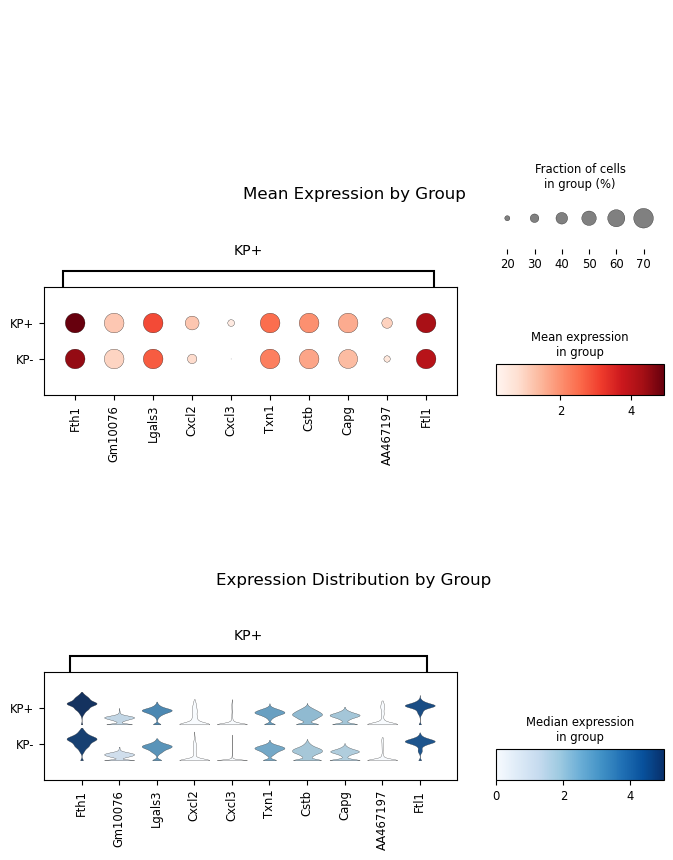

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(infected_cells, n_genes=10, key='bacterial_vs_bystander',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(infected_cells, n_genes=10, key='bacterial_vs_bystander',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

##### create the keys for infected tissue/cell type

In [91]:
# Create AM bacterial vs bystander key
am_infected_cells = infected_cells[infected_cells.obs['cell_type'] == 'AM'].copy()
sc.tl.rank_genes_groups(
    am_infected_cells,
    groupby='condition',
    groups=['KP+'],
    reference='KP-',
    method='wilcoxon',
    key_added='am_bacterial_vs_bystander')


# Create IM bacterial vs bystander key
im_infected_cells = infected_cells[infected_cells.obs['cell_type'] == 'IM'].copy()
sc.tl.rank_genes_groups(
    im_infected_cells,
    groupby='condition',
    groups=['KP+'],
    reference='KP-',
    method='wilcoxon',
    key_added='im_bacterial_vs_bystander')

#### 5. Klebsiella-Contacted IM (Interstitial Macrophage) Cells vs Bystander Cells
#### Biological Question: "Infected tissue subset: "Within infected tissue, what's different between IM cells that contacted the Klebsiella vs those that didn't?"

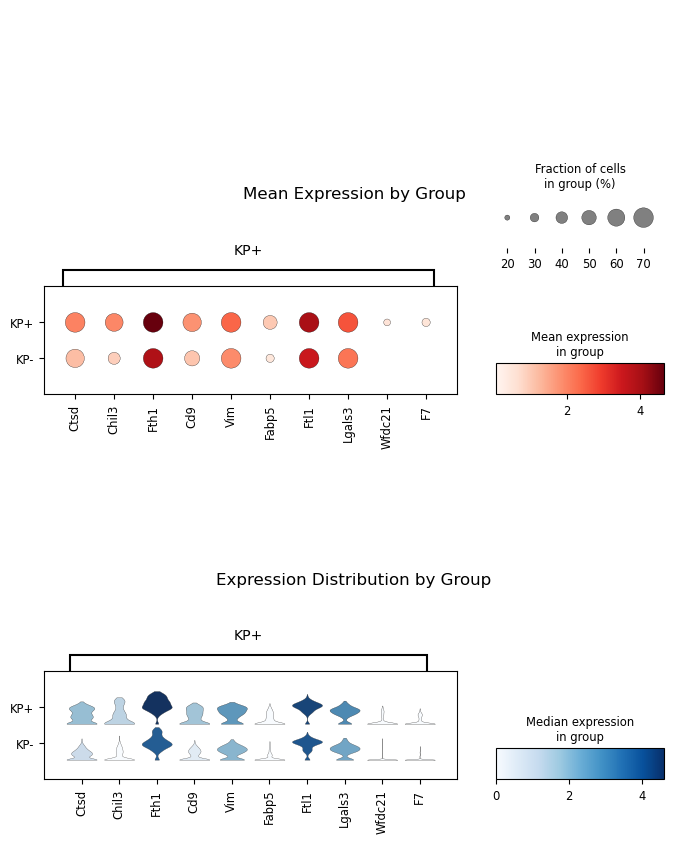

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(im_infected_cells, n_genes=10, key='im_bacterial_vs_bystander',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(im_infected_cells, n_genes=10, key='im_bacterial_vs_bystander',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

#### 6. Klebsiella-Contacted AM (Alveolar Macrophage) Cells vs Bystander Cells
#### Biological Question: "Infected tissue subset: "Within infected tissue, what's different between AM cells that contacted the Klebsiella vs those that didn't?"

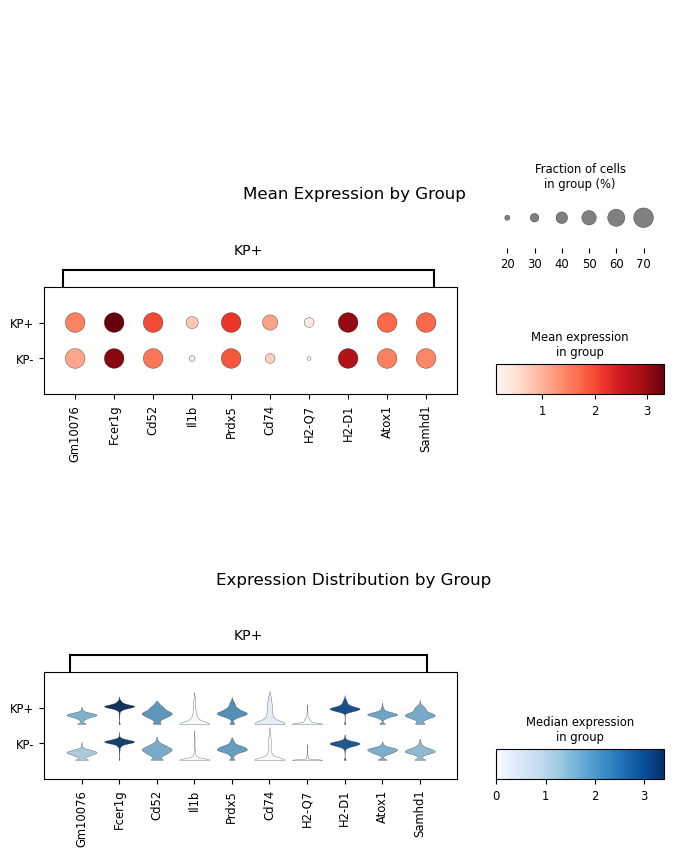

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(am_infected_cells, n_genes=10, key='am_bacterial_vs_bystander',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(am_infected_cells, n_genes=10, key='am_bacterial_vs_bystander',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

In [95]:
#save with computed DE results
adata.write('condition_DE_analysis.h5ad')
#save subsets
am_cells.write('am_cells_DE.h5ad')
im_cells.write('im_cells_DE.h5ad')
infected_cells.write('infected_cells_DE.h5ad')